# Introduction

For most retail companies, their main source of income is coming from their item sales activities whether B2B or B2C methods. By engaging in this activity, it means that the company should be using their historical data in order to predict the item outlet sales data in the future. From that, the company can do some strategic planning ahead such appropriately choose what's an outlet that needs to prioritize and what type of item that has a huge contribution to the item outlet sales.

In this notebook, I will take an initial look at the Bigmart Sales Prediction. The objective of this project is to use historical data to predict Item Outlet Sales that has a numeric outcome. This is a standard supervised regression task:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Regression__: Predict a continuous numeric outcome (in this case, predict Item Outlet Sales)

In regression problems, the output is always continuous in nature and requires no further treatment.

### Import Package

In [1]:
# required libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns',999)
from impyute.imputation.cs import mice

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import max_error,mean_squared_error,mean_absolute_error,mean_squared_log_error,median_absolute_error,r2_score

### Read Training & Testing Dataset

In [2]:
train_data = pd.read_csv('BigmartSales_train.csv')
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
test_data = pd.read_csv('BigmartSales_test.csv')
test_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is the process of visualizing and analyzing data to extract significant insights from it. In other words, EDA is the process of summarizing main characteristics of data in order to gain better understanding of the dataset.

In [4]:
# shape of the dataset
print('Shape of training data :',train_data.shape)
print('Shape of testing data :',test_data.shape)

Shape of training data : (8523, 12)
Shape of testing data : (5681, 11)


In [5]:
train_data.dtypes.value_counts()

object     7
float64    4
int64      1
dtype: int64

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
train_data.Outlet_Establishment_Year = train_data.Outlet_Establishment_Year.astype('object')
test_data.Outlet_Establishment_Year = train_data.Outlet_Establishment_Year.astype('object')

In [8]:
train_data.select_dtypes('object').head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,2009,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,1999,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,1998,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,1987,High,Tier 3,Supermarket Type1


In [9]:
train_data.Outlet_Establishment_Year.value_counts()

1985    1463
1987     932
2004     930
1999     930
1997     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [10]:
train_data.Item_Fat_Content.value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [11]:
train_data.Item_Fat_Content = train_data.Item_Fat_Content.replace('LF','Low Fat')
train_data.Item_Fat_Content = train_data.Item_Fat_Content.replace('reg','Regular')
train_data.Item_Fat_Content = train_data.Item_Fat_Content.replace('low fat','Low Fat')

test_data.Item_Fat_Content = test_data.Item_Fat_Content.replace('LF','Low Fat')
test_data.Item_Fat_Content = test_data.Item_Fat_Content.replace('reg','Regular')
test_data.Item_Fat_Content = test_data.Item_Fat_Content.replace('low fat','Low Fat')

In [12]:
train_data.Item_Fat_Content.value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [13]:
train_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914
std,4.643456,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,8.773750,0.026989,93.826500,834.247400
50%,12.600000,0.053931,143.012800,1794.331000
75%,16.850000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


### Dealing with Outliers

One problem we always want to be on the lookout for when doing EDA is anomalies/outliers within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `boxplot` method. 

As we know that sales prediction data have many consideration and client characteristics, for Item_Visibility and Item Outlet Sales it might for someone to have a huge amount of value number(outlier). So, I tried to keep the outlier since there is a chance for a buyer to buy specific things sometimes.

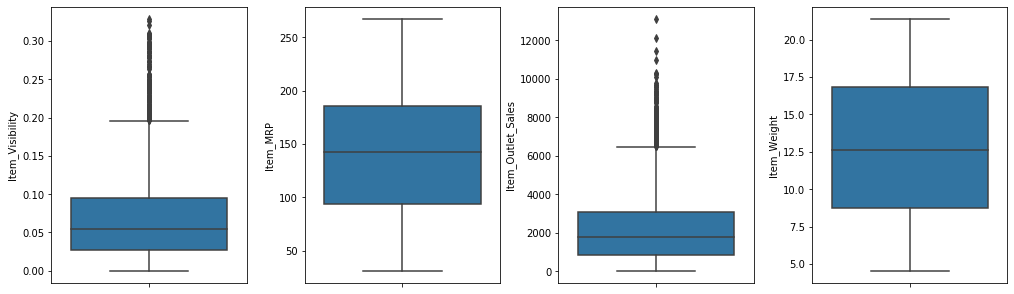

In [14]:
bx = train_data[['Item_Visibility','Item_MRP','Item_Outlet_Sales','Item_Weight']]

fig, axs = plt.subplots(ncols=4, nrows=1,figsize=(14, 4))
index = 0
axs = axs.flatten()
for k,v in bx.items():
    sns.boxplot(y=k, data=bx, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### Handling missing values

When no data value is stored for a feature in a particular observation, we say this feature has missing values. Examining this is important because when some of your data is missing, it can lead to weak or biased analysis.

We can detect missing values by applying isnull() method over the dataframe. The isnull() method returns a rectangular grid of boolean values which tells us if a particular cell in the dataframe has missing value or not.

We can handle missing values in many ways:

- **Delete:** You can delete the rows with the missing values or delete the whole column which has missing values. The dropna() method from Pandas library can be used to accomplish this task.
- **Impute:** Deleting data might cause huge amount of information loss. So, replacing data might be a better option than deleting. One standard replacement technique is to replace missing values with the average value of the entire column. For example, we can replace the missing values in “certain” column with the mean value of certain column. The fillna() method from Pandas library can be used to accomplish this task.
- **Predictive filling:** Alternatively, you can choose to fill missing values through predictive filling. The interpolate() method will perform a linear interpolation in order to “guess” the missing values and fill the results in the dataset.

In this section, I will handle missing values by predictive filling using MICE (Multivariate Imputation by Chained Equation) for numerical features and make NA as a new level in a categorical feature.

MICE is an imputation method that works by filling the missing data multiple times. Chained Equation approach also has the benefit of being able to handle different data types efficiently — such as continuous and binary.  [More details](https://impyute.readthedocs.io/en/latest/)

In [15]:
train_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [16]:
test_data.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [17]:
X_coba = train_data[['Item_Weight','Item_Visibility','Item_MRP','Item_Outlet_Sales']]
imputed = mice(X_coba.values)
train_data['Mice_Item_Weight'] = imputed[:, 0]

In [18]:
train_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Mice_Item_Weight
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914,12.852885
std,4.643456,0.051598,62.275067,1706.499616,4.226571
min,4.555000,0.000000,31.290000,33.290000,4.555000
25%,8.773750,0.026989,93.826500,834.247400,9.310000
50%,12.600000,0.053931,143.012800,1794.331000,12.813074
75%,16.850000,0.094585,185.643700,3101.296400,16.000000
max,21.350000,0.328391,266.888400,13086.964800,21.350000


We can see that with the MICE method for predictive filling, we can fill the missing values without much affected the distributions of data such as mean, median and standard deviation.

In [19]:
X_coba1 = test_data[['Item_Weight','Item_Visibility','Item_MRP']]
imputed1 = mice(X_coba1.values)
test_data['Mice_Item_Weight'] = imputed1[:, 0]

In [20]:
test_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Mice_Item_Weight
count,4705.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,12.692124
std,4.664849,0.051252,61.809091,4.246589
min,4.555000,0.000000,31.990000,4.555000
25%,8.645000,0.027047,94.412000,9.195000
50%,12.500000,0.054154,141.415400,12.620143
75%,16.700000,0.093463,186.026600,15.850000
max,21.350000,0.323637,266.588400,21.350000


In [21]:
train_data.drop(labels=['Item_Weight'], axis=1, inplace=True)
test_data.drop(labels=['Item_Weight'], axis=1, inplace=True)

In [22]:
train_data['Outlet_Size'] = train_data['Outlet_Size'].fillna('Unknown')
test_data['Outlet_Size'] = test_data['Outlet_Size'].fillna('Unknown')

### Data Analysis & Visualization

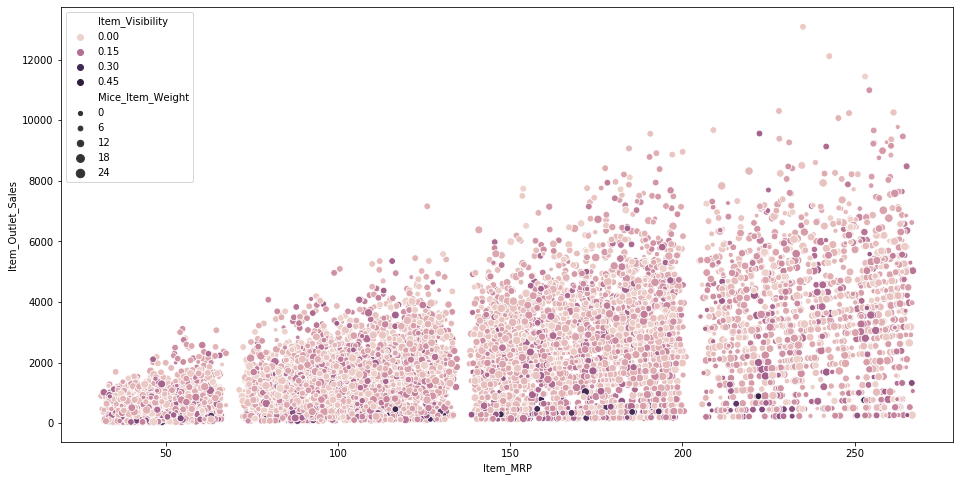

In [23]:
plt.subplots(figsize=(16,8))
sns.scatterplot(x='Item_MRP',y='Item_Outlet_Sales',hue='Item_Visibility',size='Mice_Item_Weight',data=train_data)

##### Insight

- From this graph, we know that __there are linear relations between MRP and Item sales, the high-value number of item MRP(Maximum Retail Price) affected the high item sales__ but have negative correlations between Item visibility and Item sales.

- This information also shows that the Item MRP feature has a high correlation that can affect the value numbers of item sales which inversely proportional to the item weight. It means that without we know the item identifier and item weight, we also still can predict the item sales based on the item MRP.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

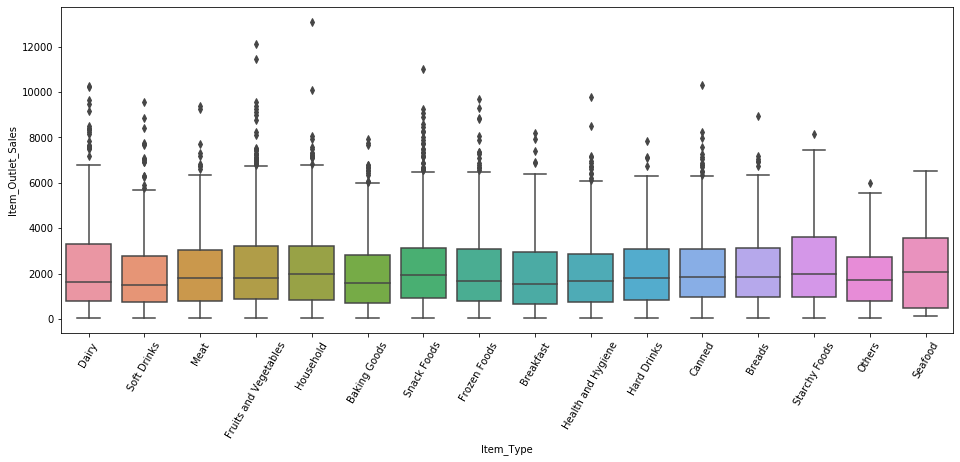

In [24]:
plt.subplots(figsize=(16,6))
sns.boxplot(x='Item_Type',y='Item_Outlet_Sales',data=train_data)
plt.xticks(rotation=60)

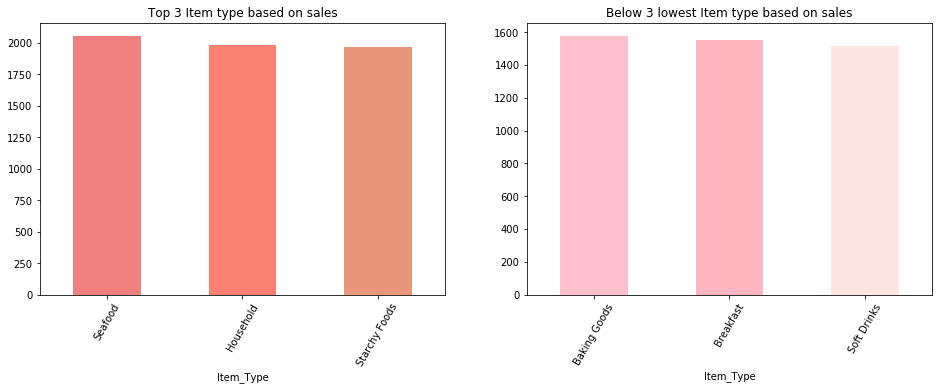

In [25]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.title('Top 3 Item type based on sales')
train_data.groupby('Item_Type')['Item_Outlet_Sales'].median().sort_values(ascending=False).head(3).plot(kind='bar',color=['lightcoral','salmon','darksalmon'])
plt.xticks(rotation=60)

plt.subplot(122)
plt.title('Below 3 lowest Item type based on sales')
train_data.groupby('Item_Type')['Item_Outlet_Sales'].median().sort_values(ascending=False).tail(3).plot(kind='bar',color=['pink','lightpink','mistyrose'])
plt.xticks(rotation=60)
plt.show()

##### Insight

- We also know what's the item type with the highest & lower item sales based on the distributions of median data.

- We can know from the information above what item type that customers tend to shop and less to buy from ten distributor outlets. We also can know what item type that we should have more produce first in order to fulfill distributor outlet stocks.

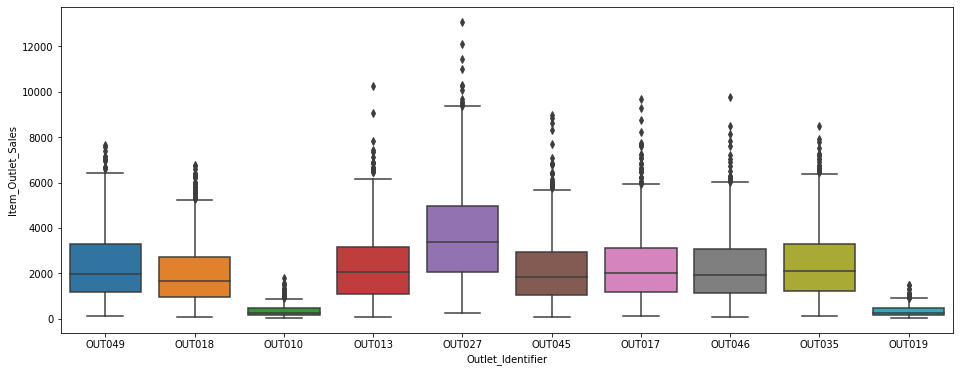

In [26]:
plt.subplots(figsize=(16,6))
sns.boxplot(x='Outlet_Identifier',y='Item_Outlet_Sales',data=train_data)

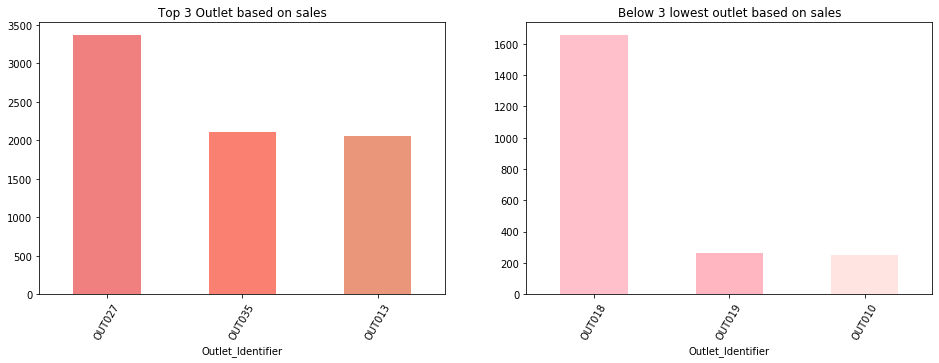

In [27]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.title('Top 3 Outlet based on sales')
train_data.groupby('Outlet_Identifier')['Item_Outlet_Sales'].median().sort_values(ascending=False).head(3).plot(kind='bar',color=['lightcoral','salmon','darksalmon'])
plt.xticks(rotation=60)

plt.subplot(122)
plt.title('Below 3 lowest outlet based on sales')
train_data.groupby('Outlet_Identifier')['Item_Outlet_Sales'].median().sort_values(ascending=False).tail(3).plot(kind='bar',color=['pink','lightpink','mistyrose'])
plt.xticks(rotation=60)
plt.show()

##### Insight

- We also know what's the outlet distributor with the highest & lower item sales based on the distributions of median data.

- This information that could be directly used by the company in many ways such as categorize outlet based on their item sales by divided into platinum, gold, and silver distributor member card, what's an outlet that needed to prioritize first to fulfill their stock items, a selection more discount and ease of payment depend on the type of member card.

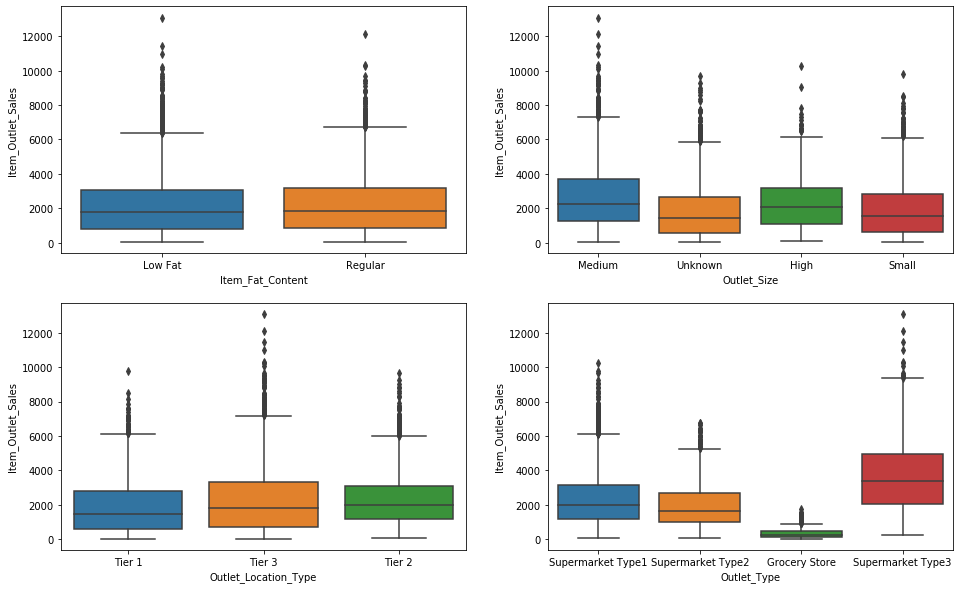

In [28]:
fig,axes = plt.subplots(2,2,figsize=(16,10))
sns.boxplot(x='Item_Fat_Content',y='Item_Outlet_Sales',ax=axes[0,0],data=train_data)
sns.boxplot(x='Outlet_Size',y='Item_Outlet_Sales',ax=axes[0,1],data=train_data)
sns.boxplot(x='Outlet_Location_Type',y='Item_Outlet_Sales',ax=axes[1,0],data=train_data)
sns.boxplot(x='Outlet_Type',y='Item_Outlet_Sales',ax=axes[1,1],data=train_data)

##### Insight

- There is a clear sign that Item Fat Content, Outlet Size, and Outlet Location has not a significant difference in item outlet sales __where outlet type has a significant difference between a grocery store and all of the supermarket type__.

- We also know that the customer tends to shop based on the outlet type than any other factors.

### Numerical Feature Data Distributions

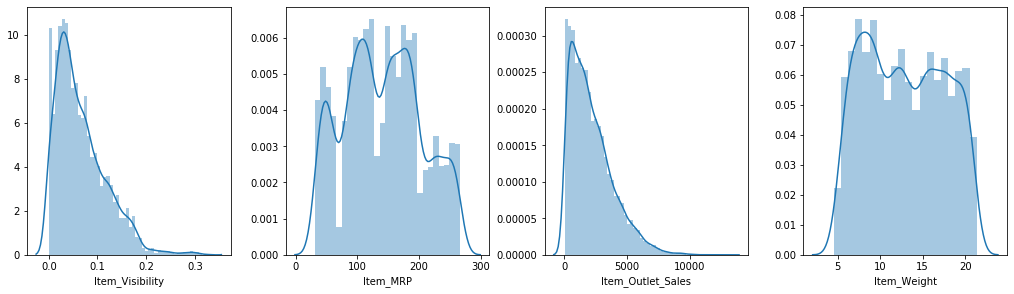

In [29]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(14, 4))
index = 0
axs = axs.flatten()
for k,v in bx.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### Log Tranformation

Logarithm transformation (or log transform) is one of the most commonly used mathematical transformations in feature engineering. What are the benefits of log transform:

- It helps to handle skewed data and after transformation, the distribution becomes more approximate to normal.
- It also decreases the effect of the outliers, due to the normalization of magnitude differences and the model become more robust.

[More details](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/)

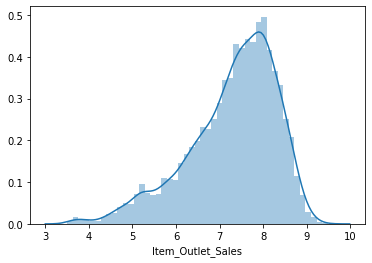

In [30]:
train_data['Item_Outlet_Sales'] = np.log(train_data['Item_Outlet_Sales'])
sns.distplot(train_data['Item_Outlet_Sales'])

### Correlation

Correlation is a statistical metric for measuring to what extent different variables are interdependent. In other words, when we look at two variables over time, if one variable changes, how does this effect change in the other variable?

For example, smoking is known to be correlated with lung cancer. Since, smoking increases the chances of lung cancer. Another example would be the relationship between the number of hours a student studies and the score obtained by that student. Because, we expect the student who studies more to obtain higher marks in the exam. We can see the correlation between different variables using the corr() function. Then we can plot a heatmap over this output to visualize the results.

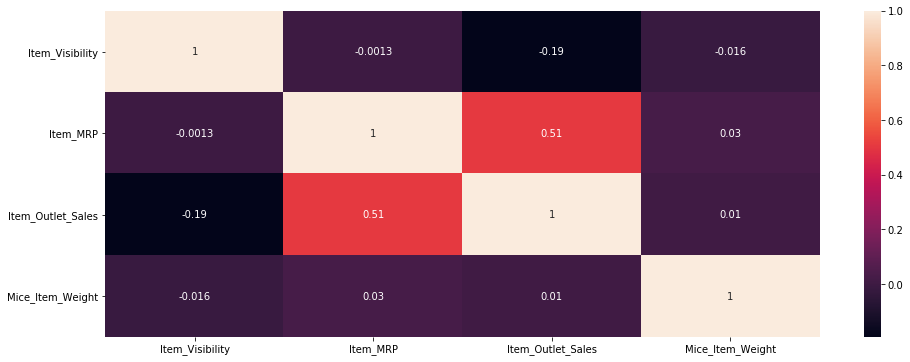

In [31]:
plt.figure(figsize=(16,6))
sns.heatmap(train_data.corr(),annot=True)
plt.show()

From the above heatmap, we can see that Item Outlet Sales and Item MRP are positively correlated(score of 0.51) with each other while, Item Visibility and Item Outlet Sales are negatively correlated(score of -0.19) with each other. In other words, it tells us that Item MRP with a huge number will be costlier than Item MRP with a small number. It also tells us that Item MRP with a huge number generally has less Item Visibility as compared to Item MRP with a small number.

Let's now look at the number of unique entries in each of the object (categorical) columns.

In [32]:
# Number of unique classes in each object column
train_data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Item_Identifier              1559
Item_Fat_Content                2
Item_Type                      16
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
dtype: int64

### Encoding Categorical Variables

Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. 

For label encoding, we use the Scikit-Learn (LabelEncoder) and for one-hot encoding, the pandas (get_dummies) function.

In [33]:
# Create a label encoder object
feature_mod = ['Item_Fat_Content']
encode = LabelEncoder()
for i in feature_mod:
    train_data[i] = encode.fit_transform(train_data[i])
    test_data[i] = encode.fit_transform(test_data[i])

train_data.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Mice_Item_Weight
0,FDA15,0,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.225540,9.30
1,DRC01,1,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.094524,5.92
2,FDN15,0,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.648392,17.50
3,FDX07,1,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Unknown,Tier 3,Grocery Store,6.596300,19.20
4,NCD19,0,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.902446,8.93


In [34]:
# one-hot encoding of categorical variables
catsub1 = train_data[['Item_Type','Outlet_Identifier','Outlet_Type','Outlet_Size','Outlet_Location_Type','Outlet_Establishment_Year','Item_Identifier']]
catsub2 = test_data[['Item_Type','Outlet_Identifier','Outlet_Type','Outlet_Size','Outlet_Location_Type','Outlet_Establishment_Year','Item_Identifier']]

catsub1 = pd.get_dummies(catsub1)
catsub2 = pd.get_dummies(catsub2)

train_data = pd.concat([train_data, catsub1], axis = 1)
test_data = pd.concat([test_data, catsub2], axis = 1)

Drop feature that has already change by One hot Encoding

In [35]:
train_data.drop(labels=['Item_Type','Outlet_Identifier','Outlet_Type','Outlet_Size','Outlet_Location_Type','Outlet_Establishment_Year','Item_Identifier'], axis=1, inplace=True)
test_data.drop(labels=['Item_Type','Outlet_Identifier','Outlet_Type','Outlet_Size','Outlet_Location_Type','Outlet_Establishment_Year','Item_Identifier'], axis=1, inplace=True)

In [36]:
print('Training Dataset shape: ',train_data.shape)
print('Testing Dataset shape: ',test_data.shape)

Training Dataset shape:  (8523, 1610)
Testing Dataset shape:  (5681, 1593)


Since we know that the differences between training and testing data are only one column so I need to align the training and testing dataset

### Aligning Training & Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes.

In [37]:
train_labels = train_data['Item_Outlet_Sales']

# Align the training and testing data, keep only columns present in both dataframes
train_data, test_data = train_data.align(test_data, join = 'inner', axis = 1)

# Add the target back in
train_data['Item_Outlet_Sales'] = train_labels

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)

Training Features shape:  (8523, 1594)
Testing Features shape:  (5681, 1593)


We know that the testing data has not included Item Outlet Sales, so I think it's a better way to split the training dataset first into training and testing data and compare the results before implemented in the real testing data for predictive results

### Split Training Dataset Into X & Y Variable

In [38]:
X = train_data.drop('Item_Outlet_Sales', axis=1)
Y = train_data['Item_Outlet_Sales']

X.shape , Y.shape

((8523, 1593), (8523,))

### Train Test Split

In [39]:
X_train ,X_test, Y_train , Y_test = train_test_split(X , Y , test_size = 0.2 , random_state=6818)

In [40]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6818, 1593)
(6818,)
(1705, 1593)
(1705,)


In this section, I deliberately using all of the feature columns without using feature selection. so that, I will be using dimensionality reduction with PCA as a feature projection to remove certain useless feature columns.

### PCA (Principal Component Analysis)

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. [More details](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 23)

# train data
X_train_new = pca.fit_transform(X_train)
X_test_new = pca.fit_transform(X_test)

# test data
test_data_new = pca.fit_transform(test_data)

In [42]:
pca.explained_variance_ratio_

array([9.93805627e-01, 4.67751257e-03, 2.11993377e-04, 1.42607859e-04,
       8.44301776e-05, 8.36206576e-05, 6.76152717e-05, 6.51298160e-05,
       5.70182425e-05, 4.08775433e-05, 3.63389760e-05, 3.41336040e-05,
       3.20683471e-05, 2.97950146e-05, 2.91805640e-05, 2.89605714e-05,
       2.85798648e-05, 2.81823341e-05, 2.76299356e-05, 2.74573845e-05,
       2.49062517e-05, 2.39373444e-05, 2.24551302e-05])

In [43]:
print(X_train_new.shape)
print(Y_train.shape)
print(X_test_new.shape)
print(Y_test.shape)

(6818, 23)
(6818,)
(1705, 23)
(1705,)


Now we're official can reduce from 1593 feature columns for just only 23 feature columns without losing the main feature columns.

# Baseline

Actually there are several model to deal with regression method. But in this case, I will try several ensemble methods model to deal with it. [More details](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

In [44]:
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train_new, Y_train)
Y_pred_rf = rf_regr.predict(X_test_new)

gbr = GradientBoostingRegressor()
gbr.fit(X_train_new, Y_train)
Y_pred_gbr = gbr.predict(X_test_new)

bagging = BaggingRegressor()
bagging.fit(X_train_new, Y_train)
Y_pred_bagging = bagging.predict(X_test_new)

ada = AdaBoostRegressor()
ada.fit(X_train_new, Y_train)
Y_pred_ada = ada.predict(X_test_new)

### Model R2 Score & RMSE

#### What is Cross Validation?

Cross Validation is a technique which involves reserving a particular sample of a dataset on which you do not train the model. Later, we test the model on this sample before finalizing it. I also using cross-validation to check if the score is stable and not overfitting

In [45]:
rf_r2_cv = cross_val_score(rf_regr,X_test_new,Y_test, scoring='r2', cv=5)
rf_r2_cv1 = rf_r2_cv.mean()
print('Random Forest R2 score after cross validation & PCA',rf_r2_cv1)

rf_rmse_cv = cross_val_score(rf_regr,X_test_new,Y_test, scoring='neg_root_mean_squared_error', cv=5)
rf_rmse_cv1 = abs(rf_rmse_cv.mean())
print('Random Forest RMSE score after cross validation & PCA',rf_rmse_cv1)

Random Forest R2 score after cross validation & PCA 0.6918149072091053
Random Forest RMSE score after cross validation & PCA 0.5643805528040985


In [46]:
gbr_r2_cv = cross_val_score(gbr,X_test_new,Y_test, scoring='r2', cv=5)
gbr_r2_cv1 = gbr_r2_cv.mean()
print('Gradient Boosting R2 score after cross validation & PCA',gbr_r2_cv1)

gbr_rmse_cv = cross_val_score(gbr,X_test_new,Y_test, scoring='neg_root_mean_squared_error', cv=5)
gbr_rmse_cv1 = abs(gbr_rmse_cv.mean())
print('Gradient Boosting RMSE score after cross validation & PCA',gbr_rmse_cv1)

Gradient Boosting R2 score after cross validation & PCA 0.7161746559790203
Gradient Boosting RMSE score after cross validation & PCA 0.540241841201573


In [47]:
bagging_r2_cv = cross_val_score(bagging,X_test_new,Y_test, scoring='r2', cv=5)
bagging_r2_cv1 = bagging_r2_cv.mean()
print('Bagging Regressor R2 score after cross validation & PCA',bagging_r2_cv1)

bagging_rmse_cv = cross_val_score(bagging,X_test_new,Y_test, scoring='neg_root_mean_squared_error', cv=5)
bagging_rmse_cv1 = abs(bagging_rmse_cv.mean())
print('Bagging Regressor RMSE score after cross validation & PCA',bagging_rmse_cv1)

Bagging Regressor R2 score after cross validation & PCA 0.660709125052309
Bagging Regressor RMSE score after cross validation & PCA 0.5831395281887787


In [48]:
ada_r2_cv = cross_val_score(ada,X_test_new,Y_test, scoring='r2', cv=5)
ada_r2_cv1 = ada_r2_cv.mean()
print('Ada Boost R2 score after cross validation & PCA',ada_r2_cv1)

ada_rmse_cv = cross_val_score(ada,X_test_new,Y_test, scoring='neg_root_mean_squared_error', cv=5)
ada_rmse_cv1 = abs(ada_rmse_cv.mean())
print('Ada Boost RMSE score after cross validation & PCA',ada_rmse_cv1)

Ada Boost R2 score after cross validation & PCA 0.6430181342180143
Ada Boost RMSE score after cross validation & PCA 0.5998019865098615


### Hyperparameter Tuning

Hyper-parameters are input into any machine learning model which generates its own parameters in order to influence the values of said generated parameters in the hope of making the model more accurate.

Since the best model for r2 score and rmse is gradient boosting regressor, I will try to using hyperparameter tuning only in that model.

In [50]:
# parameter gradient boosting yg akan dituned
param=[{'min_samples_split':[2,5,9,13],'max_leaf_nodes':[3,5,7,9,'None'],'max_features':[8,10,15,18,'None'], 'n_estimators':[10, 100, 1000], 
        'max_depth':[1,3,5,7,9],'learning_rate':[0.001,0.01,0.1]}]

# randomized search cv
modelgr = RandomizedSearchCV(estimator=gbr, param_distributions=param, cv=5)
modelgr.fit(X_train_new, Y_train)
modelgr.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'max_leaf_nodes': 9,
 'max_features': 18,
 'max_depth': 3,
 'learning_rate': 0.01}

In [54]:
gbr2 = GradientBoostingRegressor(min_samples_split=2,n_estimators=1000,max_leaf_nodes=9,max_features=18, max_depth=3, learning_rate=0.01)
gbr2.fit(X_train_new, Y_train)

gbr2_r2_cv = cross_val_score(gbr2,X_test_new,Y_test, scoring='r2', cv=5)
gbr2_r2_cv1 = gbr2_r2_cv.mean()
print('Gradient Boosting R2 HyperTuning score after cross validation & PCA',gbr2_r2_cv1)

gbr2_rmse_cv = cross_val_score(gbr2,X_test_new,Y_test, scoring='neg_root_mean_squared_error', cv=5)
gbr2_rmse_cv1 = abs(gbr2_rmse_cv.mean())
print('Gradient Boosting RMSE HyperTuning score after cross validation & PCA',gbr2_rmse_cv1)

Gradient Boosting R2 HyperTuning score after cross validation & PCA 0.7192118733239112
Gradient Boosting RMSE HyperTuning score after cross validation & PCA 0.538672690092216


### Testing Data Predict

In [55]:
test_data_new

array([[-3.31299936e+01,  8.18443352e+00,  1.33680450e-01, ...,
         1.68582425e-01,  1.08528389e-01, -9.77474985e-02],
       [-5.37197109e+01, -4.18787197e+00, -9.78380415e-01, ...,
        -1.31445128e-01,  2.35875539e-01,  3.23496197e-01],
       [ 1.00737173e+02,  1.52500912e+00,  4.94356199e-01, ...,
         1.22696964e-01,  4.43695477e-01, -6.00822685e-01],
       ...,
       [-2.22894015e+01, -2.59790968e+00, -9.81842673e-01, ...,
         2.70957023e-02,  2.93616895e-01,  1.63111888e-01],
       [ 7.36077213e+01,  2.32977298e+00, -9.73761586e-01, ...,
        -9.73805057e-02,  1.46437179e-01,  2.05789621e-01],
       [-6.12391449e+01, -2.95652896e+00, -9.74984564e-01, ...,
        -2.80045368e-01,  2.07593712e-01,  2.66888258e-01]])

In [56]:
Y_pred_gbr_pca = gbr2.predict(test_data_new)

In [57]:
Y_pred_gbr_pca

array([5.46892569, 7.16726852, 7.35949008, ..., 7.5342605 , 7.57182766,
       6.74714927])

In [58]:
test_data['Item_Outlet_Sales'] = pd.DataFrame(Y_pred_gbr_pca, columns=['Item_Outlet_Sales'])

In [59]:
test_data['Item_Outlet_Sales']

0       5.468926
1       7.167269
2       7.359490
3       7.583809
4       8.207381
          ...   
5676    7.506673
5677    7.313011
5678    7.534261
5679    7.571828
5680    6.747149
Name: Item_Outlet_Sales, Length: 5681, dtype: float64

Since I using log transformation for boosting the R2 score to predictive result values, now it's time to using inverse transformation for changing the log shape to become the real predictive value numbers.

In [60]:
test_data['Item_Outlet_Sales'] = np.exp(test_data['Item_Outlet_Sales'])
test_data['Item_Outlet_Sales']

0        237.205225
1       1296.298946
2       1571.035250
3       1966.102970
4       3667.921831
           ...     
5676    1820.148285
5677    1499.686221
5678    1871.060204
5679    1942.687608
5680     851.627539
Name: Item_Outlet_Sales, Length: 5681, dtype: float64

In [61]:
test = pd.read_csv('BigmartSales_test.csv')

In [62]:
test = pd.concat([test, test_data['Item_Outlet_Sales']], axis = 1)

In [63]:
test[['Item_Identifier','Item_Type','Item_MRP','Outlet_Identifier','Item_Outlet_Sales']].head()

,Item_Identifier,Item_Type,Item_MRP,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,Snack Foods,107.8622,OUT049,237.205225
1,FDW14,Dairy,87.3198,OUT017,1296.298946
2,NCN55,Others,241.7538,OUT010,1571.035250
3,FDQ58,Snack Foods,155.0340,OUT017,1966.102970
4,FDY38,Dairy,234.2300,OUT027,3667.921831


# Final summary

**From above data engineering and machine learning techniques we can conclude that:**

- Features Item Visibility, Item Type, Item MRP, Outlet Identifier and Outlet Type are alone capable of predicting Item Outlet Sales to a good accuracy.
- Gradient Boosting regression model can be considered as a good model for predicting Item Outlet Sales than any others using features.
- The company can be focused on fulfilling the distributor stock outlet by forecasting they needed in certain item types that will affect the Item Outlet Sales.

I would like to close it by mentioning that no data science technique is perfect and there is always scope for improvement. I also open to any other constructive comment that will be helped.